# Micrograd
From [Andrej Karpathys video]("""https://www.youtube.com/watch?v=VMj-3S1tku0""")

In [18]:
import math
import random

In [55]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [6]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'
L.grad = 1.0

In [7]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

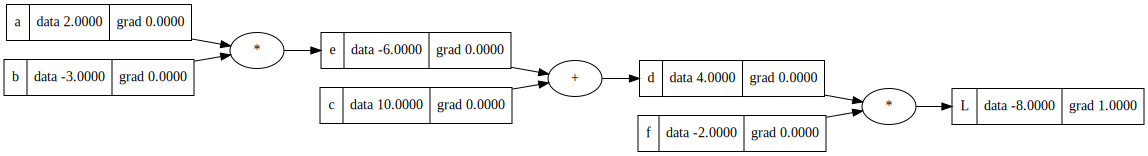

In [20]:
draw_dot(L)

In [8]:
f.grad  = 4.0
d.grad = -2.0
c.grad = -2.0 * 1.0
e.grad = -2.0 * 1.0
a.grad = -2.0 * -3.0
b.grad = -2.0 * 2.0

In [9]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)

In [10]:
lol()

3.9999999999995595


In [11]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'



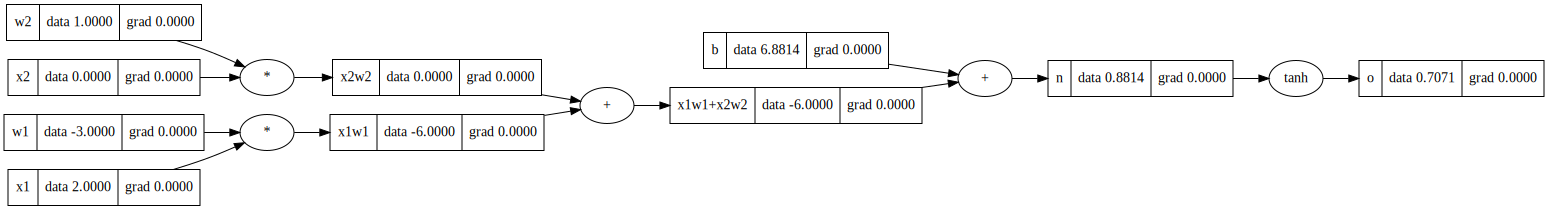

In [12]:
draw_dot(o)

In [13]:
o.backward()

In [14]:
import torch


/home/aditya/miniconda3/envs/neural_nets/lib/python3.10/site-packages/torch/_subclasses/functional_tensor.py:295: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


In [15]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [225]:
class Neuron:
	def __init__(self, nin):
		self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
		self.b = Value(random.uniform(-1,1))
	def __call__(self, x): 
		act = sum((wi*xi for wi, xi in zip(self.w, x)),self.b)
		out = act.tanh()
		return out			
	def parameters(self):
		return self.w + [self.b]

In [226]:
class Layer:
	def __init__(self, nin, nout):
		self.neurons = [Neuron(nin) for _ in range(nout)]
	def __call__(self, x):
		outs = [n(x) for n in self.neurons]
		return outs[0] if len(outs) == 1 else outs
	def parameters(self):
		return [p for neuron in self.neurons for p in neuron.parameters()]
	

In [227]:
class MLP:
	def __init__(self, nin, nouts):
		sz = [nin] + nouts
		self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
	def __call__(self, x):
		for layer in self.layers:
			x = layer(x)
		return x
	def parameters(self):
		return [p for layer in self.layers for p in layer.parameters()]
	

In [228]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.28367505025585843)

In [229]:
len(m.parameters())

41

In [230]:
xs = [
	[2.0, 3.0, -1.0],
	[3.0, -1.0, 0.5],
	[0.5, 1.0, 1.0],
	[1.0, 1.0, -1.0]
]

ys = [1.0,-1.0, -1.0, 1.0]



In [241]:
for k in range(20):

	# forward pass
	ypred = [n(x) for x in xs]
	loss =sum([(yout-ygt)**2 for ygt, yout in zip(ys, ypred)])

	# backward pass
	for p in n.parameters():
		p.grad = 0
	loss.backward()

	# update
	for p in n.parameters():
		p.data += -0.05 * p.grad

	# display
	print(k, loss.data, ypred)


0 0.003828937720510411 [Value(data=0.9697052492297932), Value(data=-0.9709418981636998), Value(data=-0.9681900927356566), Value(data=0.9675204323645381)]
1 0.0038069332705829638 [Value(data=0.9697918047998026), Value(data=-0.9710225505003571), Value(data=-0.968286686629307), Value(data=0.9676121722111901)]
2 0.003785175635786193 [Value(data=0.9698776397267391), Value(data=-0.9711025519638464), Value(data=-0.9683824382681162), Value(data=0.96770315287087)]
3 0.0037636607187213214 [Value(data=0.9699627638903846), Value(data=-0.9711819112270343), Value(data=-0.9684773596204926), Value(data=0.967793384707575)]
4 0.0037423845118108173 [Value(data=0.970047186982465), Value(data=-0.9712606368019175), Value(data=-0.9685714624202261), Value(data=0.9678828778886893)]
5 0.003721343094856839 [Value(data=0.97013091851122), Value(data=-0.9713387370434404), Value(data=-0.9686647581723347), Value(data=0.9679716423897488)]
6 0.0037005326326786797 [Value(data=0.9702139678058391), Value(data=-0.971416220